In [3]:
import json
import csv
import pandas as pd
from pandas import DataFrame, Series
import dateutil.parser
from dateutil.tz import gettz
import datetime
import pytz
from functools import reduce
import time
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import calendar
from time import mktime
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# def roundUnixTime(timestamp):
#     timestamp = timestamp - (timestamp % 3600)
#     return timestamp

def convertTime(timestamp):
    timestamp = time.gmtime(timestamp)
    return timestamp

def convertUTCToTimestamp(timestamp):
    nanosecondTimestamp = timestamp * 1e9
    timestamp = pd.Timestamp(nanosecondTimestamp, tz='US/Eastern')
    return timestamp

def convertTimeToStruct(timestamp):
    timestamp = time.gmtime(timestamp)
    return timestamp

In [5]:
#mood reporter DF

responsesDF = pd.read_csv("../reporter/responses.tsv", sep='\t', header=0)

timeValues = responsesDF.unix_time.values


activity_names = list(set(list(map(lambda x: x.lower().strip(), reduce(lambda x,y: x+y, [x.split(",") for x in list(responsesDF.activity.values)])))))

for activity_name in activity_names:
    responsesDF[activity_name.replace(" ", "_") + "_activity"] = responsesDF.activity.apply(lambda x: activity_name in x.lower())

location_names = list(set(list(map(lambda x: x.lower().strip(), reduce(lambda x,y: x+y, [x.split(",") for x in list(responsesDF.location.values)])))))

def split_locations(locations):
    return list(map(lambda x: x.lower().strip(), locations.split(",")))

for location_name in location_names:
    responsesDF[location_name.replace(" ", "_") + "_location"] = responsesDF.location.apply(lambda x: location_name in split_locations(x))

# responsesDF.time = responsesDF.unix_time.apply(roundUnixTime)
# responsesDF.time = responsesDF.time.apply(convertTime)
responsesDF.time = responsesDF.unix_time

del responsesDF['moodNotes']
del responsesDF['trigger']
del responsesDF['activity']
del responsesDF['location']
del responsesDF['unix_time']


# outputsDF = responsesDF[['time','mood', 'morale', 'stress', 'unique_interactions', 'fatigue', 'compulsions', 'alone']].copy()

responsesDF.time = responsesDF.time.apply(convertUTCToTimestamp)

In [6]:
tone_names = ['Sadness', 'Analytical', 'Joy', 'Fear', 'Tentative', 'Anger', 'Confident']
#keylogger DF


with open('../keylogger/logs/log_new.json', 'r') as f:
    keyloggerData = json.load(f)

# tzinfos = { "EDT" : gettz("America/New_York") }

def extract_keyloggerData(data):
    keyloggerResults = []
    keystrokeWordCountResults = []

    for d in data:
#         result = [0]*(len(tone_names) + 6)
        keyloggerResult = [0] * (len(tone_names)+1)
        keystrokeWordCountResult = [0] * 6
        
        tones = d['document_tone']['tones']
        for i in range(len(tones)):
            score = tones[i]['score']
            tone_name = tones[i]['tone_name']
            tone_index = tone_names.index(tone_name)
            keyloggerResult[tone_index] = score            

        keyloggerResult[-1] = d['unix_time']

        keyloggerResults.append(tuple(keyloggerResult))
        
        try:
            keystrokeWordCountResult[0] = d['word_count']
            keystrokeWordCountResult[1] = d['uniqueword_ratio']
            keystrokeWordCountResult[2] = d['backspace_count']
            keystrokeWordCountResult[3] = d['avg_dwelltime']
            keystrokeWordCountResult[4] = d['avg_flighttime']
            keystrokeWordCountResult[5] = d['unix_time']
            
            keystrokeWordCountResults.append(tuple(keystrokeWordCountResult))
            
        except:
            continue
            
    return keyloggerResults, keystrokeWordCountResults

both = extract_keyloggerData(keyloggerData)

keyloggerDF = DataFrame(both[0],
                        columns=[tone_name+"_score" for tone_name in tone_names] + ['time'])

keystrokeWordCountDF = DataFrame(both[1],
                        columns=['word_count', 'uniqueword_ratio', 'backspace_count', 'avg_dwelltime', 'avg_flighttime', 'time'])

keyloggerDF.time = keyloggerDF.time.apply(convertUTCToTimestamp)
keyloggerDF.sort_values('time', inplace=True)

keystrokeWordCountDF.time = keystrokeWordCountDF.time.apply(convertUTCToTimestamp)
keystrokeWordCountDF.sort_values('time', inplace=True)

In [7]:
#affectiva DF


with open('../getAPIdata/merged_file.json', 'r') as f:
    affectivaData = json.load(f)

for x in range(0, len(affectivaData)):
#         affectivaData[x]['time'] = time.gmtime(affectivaData[x]['time']/ 1e3)
        affectivaData[x]['time'] = affectivaData[x]['time']/ 1e3
        affectivaData[x]['emoji'] = len(affectivaData[x]['emoji'])

#     affectivaData[x]['time'] = utc_to_local(datetime.datetime.fromtimestamp((affectivaData[x]['time']/ 1e3)))


affectivaDF = DataFrame(affectivaData)

del affectivaDF['emotions']
del affectivaDF['max_attention']
del affectivaDF['min_attention']
del affectivaDF['max_engagement']
del affectivaDF['min_engagement']
del affectivaDF['max_valence']
del affectivaDF['min_valence']
affectivaDF.time = affectivaDF.time.apply(convertUTCToTimestamp)
affectivaDF.sort_values('time', inplace=True)

In [8]:
#productivity DF
from dateutil import parser
import calendar

with open('../getAPIdata/productivity.json', 'r') as f:
    productivityFile = json.load(f)

productivityData = productivityFile['rows']

final_productivityData = [];
UTC = pytz.timezone('UTC')

for x in range(0, len(productivityData)):
#     if(productivityData[x][0] > '2018-04-01T00:00:00'):
    date = parser.parse(productivityData[x][0])
    dateutc = str(date.astimezone(UTC))
    dateutc2 = dateutc[:19] + "UTC"
    newtime = time.strptime(dateutc2, "%Y-%m-%d %H:%M:%S%Z")
    finalTime = calendar.timegm(newtime)
    prod_score = productivityData[x][4]
    final_productivityData.append((finalTime, prod_score))

productivityDF = DataFrame(final_productivityData, columns=['time', 'productivity_score'])
productivityDF.time = productivityDF.time.apply(convertUTCToTimestamp)

productivityDF.sort_values('time', inplace=True)

In [9]:
qualityTimeDF = pd.read_csv("../QualityTime/1538685540767_ENTIRE_HISTORY_1475613536545_1538685536545.csv", header=0)
qtTimeVals = qualityTimeDF.End_Time.values

newQTtimeVals = []
for x in range(0, len(qtTimeVals)):
#     timestamp = int(qtTimeVals[x]) / 1e3
    timestamp = time.gmtime(int(qtTimeVals[x]) / 1e3)
#     time = utc_to_local(datetime.datetime.fromtimestamp((int(qtTimeVals[x])/ 1e3)))
    newQTtimeVals.append(timestamp)

    
usageVals = qualityTimeDF.Usage.values
newQTusageVals = []

for x in range(0, len(usageVals)):
    string = usageVals[x]
    minSubstring = "min"
    hrSubstring = "hr"
    finalSecs = 0
    
    if hrSubstring in string:
        removeHr = string[0:1]
        newHr = int(removeHr) * 3600
        finalSecs += newHr
    elif minSubstring in string:
        removeMin = string[-6:-4]
        newMin = int(removeMin) * 60
        finalSecs += newMin
    else:
        removeSec = string[0:-4]
        newSec = int(removeSec)
        finalSecs += newSec
        
    newQTusageVals.append(finalSecs)


qualityTimeDF.End_Time = newQTtimeVals
qualityTimeDF.Usage = newQTusageVals
qualityTimeDF = qualityTimeDF[['End_Time', 'Usage']]
qualityTimeDF.columns = ['time', 'usage_in_sec']

compressed = []
current_hour = qualityTimeDF['time'][0]
# current_hour = qualityTimeDF['time'][0].replace(microsecond=0,second=0,minute=0)
total_usage = 0
unlocks = 0

for index, row in qualityTimeDF.iterrows():
    if (index == len(qualityTimeDF) -1):
        holder = [0] * 3
        holder[0] = current_hour
        holder[1] = unlocks
        holder[2] = total_usage
        compressed.append(tuple(holder))
    elif (row['time'].tm_year == current_hour.tm_year and row['time'].tm_mon == current_hour.tm_mon and row['time'].tm_mday == current_hour.tm_mday and row['time'].tm_hour == current_hour.tm_hour):
        total_usage += row['usage_in_sec']
        unlocks +=1
    else:
        holder = [0] * 3
        holder[0] = current_hour
        holder[1] = unlocks
        holder[2] = total_usage
        compressed.append(tuple(holder))
        total_usage = 0
        unlocks = 0
        current_hour = row['time']
#         current_hour = row['time'].replace(microsecond=0,second=0,minute=0)
        total_usage += row['usage_in_sec']
        unlocks +=1
        

newQTDF = DataFrame(compressed, columns = ['time', 'phone_unlocks', 'phone_use_secs'])
newQTDF.time = newQTDF.time.apply(mktime)
newQTDF.time = newQTDF.time.apply(convertUTCToTimestamp)

newQTDF.sort_values('time', inplace=True)


In [10]:
# google fit

with open('../google_fit/dataset.json', 'r') as f:
    fitData = json.load(f)
    

stepCountCompressed = []

def extract_fitData(fitData):
    current_timestamp = int(fitData[0]['endTimeNanos']) / 1e9
    current_hour = convertTimeToStruct(int(fitData[0]['endTimeNanos']) / 1e9)
    stepCount = 0

    for d in fitData:
        dHour = convertTimeToStruct(int(d['endTimeNanos']) / 1e9)
        if (dHour.tm_year == current_hour.tm_year and dHour.tm_mon == current_hour.tm_mon and dHour.tm_mday == current_hour.tm_mday and dHour.tm_hour == current_hour.tm_hour):
            stepCount += int(d['value'][0]['intVal'])
        else:
            holder = [0] * 2
            holder[0] = current_timestamp
#             holder[1] = current_hour
            holder[1] = stepCount
            
            stepCountCompressed.append(tuple(holder))
            stepCount = 0

            current_hour = convertTimeToStruct(int(d['endTimeNanos']) / 1e9)
            current_timestamp = int(d['endTimeNanos']) / 1e9

            stepCount += int(d['value'][0]['intVal'])

extract_fitData(fitData['point'])


stepCountDF = DataFrame(stepCountCompressed, columns = ['time', 'stepCount'])
# exerciseDF.time = exerciseDF.time.apply(convertTimeToUnix)

stepCountDF.time = stepCountDF.time.apply(convertUTCToTimestamp)
stepCountDF.sort_values('time', inplace=True)

In [11]:
#tabcounter

with open('../getAPIdata/chromeactivity.json', 'r') as f:
    tabCounterData = json.load(f)

newTabData = []

for key in tabCounterData:
    timestamp = int(key) / 1e3

#     timestamp = time.gmtime(int(key) / 1e3)
#     time = utc_to_local(datetime.datetime.fromtimestamp((int(key)/ 1e3)))
    current_tabCount = tabCounterData[key]['current_tabCount']
    current_windowCount = tabCounterData[key]['current_windowCount']
    tabs_activated = tabCounterData[key]['tabs_activated']
    tabs_created = tabCounterData[key]['tabs_created']
    windows_created = tabCounterData[key]['windows_created']

    newTabData.append([timestamp, current_tabCount, current_windowCount,tabs_activated,tabs_created,windows_created])

tabColumns = ['time', 'current_tabCount', 'current_windowCount','tabs_activated','tabs_created','windows_created']
tabCounterDF = DataFrame(newTabData, columns=tabColumns)
# tabCounterDF.time = tabCounterDF.time.apply(roundTime)

tabCounterDF.time = tabCounterDF.time.apply(convertUTCToTimestamp)

tabCounterDF.sort_values('time', inplace=True)


In [12]:
heartRateDF = pd.read_csv("../webcam-pulse-detector-no_openmdao/heartRate.csv", sep=',', header=0)

heartRateDF.time = heartRateDF.time.apply(convertUTCToTimestamp)
heartRateDF.sort_values('time', inplace=True)
heartRateDF = heartRateDF.reset_index(drop=True)

In [13]:
def hourOnly(timestamp):
    timestamp = timestamp.hour
#     if (timestamp < 6):
#         timestamp = timestamp + 24
    return timestamp


hourColumn = pd.to_datetime(responsesDF.time, unit='s')
hourDF = DataFrame(hourColumn)
hourDF.sort_values('time', inplace=True)
hourDF['hour'] = hourDF.time.apply(hourOnly)


In [14]:
# outputsDF['rolling_mean_mood'] = outputsDF['mood'].rolling(25).mean()
# outputsDF.dropna(inplace=True)
# outputsDF.reset_index(inplace=True)
# del outputsDF['index']

In [15]:
# outputsDF['mood_mean_difference'] = outputsDF['rolling_mean_mood'] - outputsDF['mood']
# outputsDF

In [42]:
mergedDF1 = pd.merge_asof(keyloggerDF, keystrokeWordCountDF, on='time', tolerance=pd.Timedelta('1 hours')).dropna()
mergedDF1.reset_index(inplace=True)
del mergedDF1['index']

mergedDF2 = pd.merge_asof(affectivaDF, mergedDF1, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
mergedDF2.reset_index(inplace=True)
del mergedDF2['index']

mergedDF3 = pd.merge_asof(mergedDF2, stepCountDF, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).fillna(0)
mergedDF3.reset_index(inplace=True)
del mergedDF3['index']

mergedDF4 = pd.merge_asof(mergedDF3, tabCounterDF, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
mergedDF4.reset_index(inplace=True)
del mergedDF4['index']

mergedDF5 = pd.merge_asof(mergedDF4, productivityDF, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
mergedDF5.reset_index(inplace=True)
del mergedDF5['index']

mergedDF6 = pd.merge_asof(mergedDF5, newQTDF, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
mergedDF6.reset_index(inplace=True)
del mergedDF6['index']

# mergedDF7 = pd.merge_asof(mergedDF6, heartRateDF, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
# mergedDF7.reset_index(inplace=True)
# del mergedDF7['index']

mergedDF8 = pd.merge_asof(responsesDF, hourDF, on='time', direction='nearest', tolerance=pd.Timedelta('1 hours')).dropna()
mergedDF8.reset_index(inplace=True)
del mergedDF8['index']

finalMergedDF = pd.merge_asof(mergedDF8, mergedDF6, on='time', direction='nearest', tolerance=pd.Timedelta('1.5 hours')).dropna()
finalMergedDF.reset_index(inplace=True)
del finalMergedDF['index']

finalMergedDF

,time,mood,unique_interactions,alone,morale,stress,fatigue,compulsions,feedly_activity,_activity,...,avg_flighttime,stepCount,current_tabCount,current_windowCount,tabs_activated,tabs_created,windows_created,productivity_score,phone_unlocks,phone_use_secs
0,2018-05-30 23:43:50.779942912-04:00,3.5,0,True,3.5,0.0,3.0,True,False,True,...,0.171138,0.0,26.0,2.0,19.0,4.0,0.0,51.70,19.0,358.0
1,2018-05-31 00:54:24.027759104-04:00,3.0,0,True,2.0,0.0,3.5,True,False,True,...,0.171138,0.0,26.0,2.0,19.0,4.0,0.0,51.70,19.0,358.0
2,2018-06-02 15:37:29.052293120-04:00,2.5,0,True,2.0,3.5,2.5,True,True,True,...,0.208556,1121.0,25.0,2.0,62.0,7.0,0.0,20.13,7.0,59.0
3,2018-06-02 16:40:40.727516928-04:00,2.5,3,True,2.0,2.0,1.5,False,True,True,...,0.208556,1121.0,25.0,2.0,62.0,7.0,0.0,20.13,7.0,59.0
4,2018-06-02 19:08:28.065821184-04:00,3.0,1,True,2.5,1.0,1.0,False,False,True,...,0.311904,10.0,25.0,2.0,4.0,0.0,0.0,34.25,6.0,840.0
5,2018-06-02 20:19:14.888844032-04:00,3.0,0,True,3.0,0.0,1.5,False,False,True,...,0.311904,10.0,23.0,2.0,0.0,0.0,0.0,33.50,14.0,902.0
6,2018-06-02 21:25:25.471260160-04:00,3.0,0,True,2.5,0.0,1.5,True,False,True,...,0.281055,0.0,23.0,2.0,16.0,4.0,0.0,22.86,17.0,724.0
7,2018-06-02 22:25:59.244112896-04:00,2.5,0,True,2.0,0.0,2.0,True,False,True,...,0.281055,0.0,23.0,2.0,0.0,0.0,0.0,42.77,11.0,1260.0
8,2018-06-02 23:26:34.387373056-04:00,3.0,0,True,3.0,0.0,2.5,False,False,True,...,0.281055,0.0,23.0,2.0,0.0,0.0,0.0,42.77,11.0,1260.0
9,2018-06-03 15:01:05.512634880-04:00,3.5,2,True,3.5,0.0,1.5,False,False,True,...,0.177798,0.0,24.0,2.0,10.0,2.0,0.0,69.28,13.0,1211.0


In [42]:
# finalMergedDF.to_csv("mergedDF_noHR.tsv", sep='\t', encoding='utf-8')

In [ ]:
# from sklearn.externals import joblib
# joblib.dump(finalMergedDF, '/Users/jxu2/github/thesis_explorations/life_support/predictor/finalMergedDF.pkl') 


In [43]:
corr = finalMergedDF.corr().fillna(0)

In [44]:
import seaborn as sns

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)


corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '30px', 'min-width': '60px', 'min-height': '60px', 'max-height': '60px', 'font-size': '8pt', 'padding': '1em 1em'})\
    .set_precision(2)

In [45]:
corr.corr().mood.sort_values(ascending=False)

mood                            1.000000
morale                          0.781689
with_friends_activity           0.651094
school_location                 0.533002
unique_interactions             0.495794
emoji                           0.360182
productivity_score              0.350631
Joy_score                       0.335102
in_class_activity               0.330244
avg_engagement                  0.324951
with_k_activity                 0.304148
stepCount                       0.290266
k_home_location                 0.258133
eating_activity                 0.252796
current_windowCount             0.237729
work_activity                   0.232237
Analytical_score                0.228774
cafe_location                   0.220291
mountain_view_location          0.200533
schoolwork_activity             0.199024
current_tabCount                0.191551
vacation_location               0.186791
hour                            0.173627
sstudying_activity              0.160715
backspace_count 

In [47]:
corr.corr().stress.sort_values(ascending=False)

stress                          1.000000
current_windowCount             0.434488
current_tabCount                0.428504
tabs_activated                  0.364521
fatigue                         0.307595
Anger_score                     0.290747
school_location                 0.261781
word_count                      0.260882
Fear_score                      0.254610
parents_home_location           0.242406
in_class_activity               0.239596
Sadness_score                   0.236330
windows_created                 0.225012
unique_interactions             0.201812
airport_location                0.195251
chatting_activity               0.194862
tabs_created                    0.167982
backspace_count                 0.159614
commuting_activity              0.148653
Analytical_score                0.127639
washing_up_activity             0.100228
reading_activity                0.099175
meditation_activity             0.093559
schoolwork_activity             0.078084
work_activity   

In [46]:
corr.corr().blinks.sort_values(ascending=False)

blinks                          1.000000
emoji                           0.247920
cooking_activity                0.218742
avg_valence                     0.174534
feedly_activity                 0.154687
avg_engagement                  0.154453
home_location                   0.145158
stepCount                       0.143195
errands_activity                0.116908
leisure_activity                0.116610
chatting_activity               0.089320
eating_activity                 0.087107
avg_attention                   0.081698
Joy_score                       0.081159
phone_unlocks                   0.070223
windows_created                 0.062413
tabs_created                    0.059712
mood                            0.052637
phone_use_secs                  0.049691
Anger_score                     0.048951
therapy_activity                0.045943
unique_interactions             0.041357
fatigue                         0.039933
tv_activity                     0.036961
commuting_activi

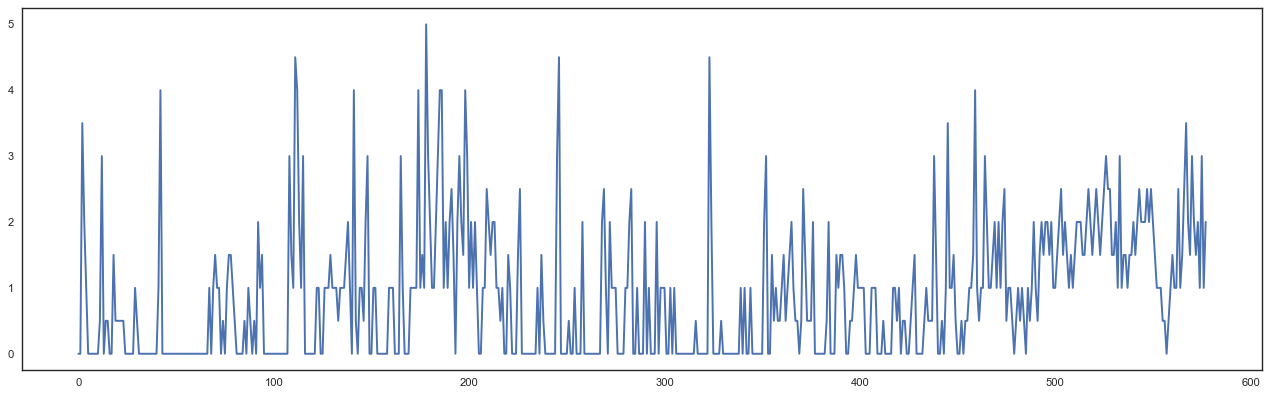

In [59]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(finalMergedDF["stress"])
plt.show()

In [70]:
from sklearn.svm import SVR

from sklearn import ensemble

y_mood_mean_difference = finalMergedDF["mood_mean_difference"]
y_morale = finalMergedDF["morale"]
y_mood = finalMergedDF["mood"]
y_stress = finalMergedDF["stress"]

finalFeaturesList = list(finalMergedDF.columns.drop('time').drop("mood").drop("morale").drop("stress").drop("unique_interactions").drop("fatigue").drop("compulsions").drop("alone").drop("rolling_mean_mood").drop("mood_mean_difference"))
X = finalMergedDF[finalFeaturesList]

# morale
X_train, X_test, y_stress_train, y_stress_test = train_test_split(
    X, y_stress, test_size=0.20, shuffle=False)


# morale
X_train, X_test, y_morale_train, y_morale_test = train_test_split(
    X, y_morale, test_size=0.20, shuffle=False)

morale_RF = ensemble.RandomForestRegressor(bootstrap=True, max_features='sqrt', max_depth=120, min_samples_leaf=9, min_samples_split=6, n_estimators=450)
morale_RF = morale_RF.fit(X_train, y_morale_train)


# mood-mean-difference
# {'C': 1.5, 'epsilon': 0.3, 'gamma': 1e-07, 'kernel': 'rbf'}

X_train, X_test, y_mood_mean_difference_train, y_mood_mean_difference_test = train_test_split(
    X, y_mood_mean_difference, test_size=0.20, shuffle=False)

# mood_mean_diff_SVR = SVR(C=32, epsilon=0.42, gamma=1e-07, kernel='rbf')
# mood_mean_diff_SVR = mood_mean_diff_SVR.fit(X_train, y_mood_mean_difference_train)

mood_mean_diff_RF = ensemble.RandomForestRegressor(bootstrap=True, max_features='sqrt', max_depth=120, min_samples_leaf=9, min_samples_split=6, n_estimators=450)
mood_mean_diff_RF = mood_mean_diff_RF.fit(X_train, y_mood_mean_difference_train)


# print(morale_LM.score(X_test, y_morale_test))
# print(stress_RF.score(X_test, y_stress_test))
# print(social_LM.score(X_test, y_social_test))
# print(fatigue_LM.score(X_test, y_fatigue_test))
# print(compulsions_LM.score(X_test, y_compulsions_test))
# print(alone_LM.score(X_test, y_alone_test))
print(morale_RF.score(X_test, y_morale_test))
# print(mood_mean_diff_SVR.score(X_test, y_mood_mean_difference_test))
print(mood_mean_diff_RF.score(X_test, y_mood_mean_difference_test))




0.124704972332
0.0607970230656


In [61]:
from sklearn.externals import joblib

joblib.dump(mood_mean_diff_RF, '/Users/jxu2/github/thesis_explorations/life_support/predictor/mood_mean_diff_RF.pkl') 


['/Users/jxu2/github/thesis_explorations/life_support/predictor/mood_mean_diff_RF.pkl']

In [ ]:
finalFeaturesList

In [ ]:
rolling_mean = y_mood.iloc[-30:-1].mean()

mood_mean_diff_RF.predict(X_test.iloc[-1].reshape(1, -1)) + rolling_mean

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 115, 120, 125, 130],
    'max_features': ['sqrt'],
    'min_samples_leaf': [6, 7, 8, 9],
    'min_samples_split': [4, 5, 6, 7, 8],
    'n_estimators': [450, 500, 450]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = mood_mean_diff_RF, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train, y_mood_mean_difference_train)

In [ ]:
grid_search.best_params_